# Problem2: Optimal Bayesian Estimation

# 0- First Some Data Pre-Processing

- At this moment you should have "train_PCA.pkl" and "test_PCA.pkl" files in your working directory

In [1]:
import pickle
import numpy as np
import math


# train_data=pickle.load(open( "train_PCA.pkl", "rb" ),encoding ='latin1')
# test_data=pickle.load(open( "test_PCA.pkl", "rb" ),encoding ='latin1')

train_data=pickle.load(open( "train_PCA.pkl", "rb" ))
test_data=pickle.load(open( "test_PCA.pkl", "rb" ))

In [2]:
categories = ['alt.atheism',
              'talk.religion.misc',
              'comp.graphics',
              'sci.space']

num_classes = len(categories)

In [3]:
val_ratio  = 0.1 
e=math.e
L = [e**-25, e**-20, e**-15, e**-10, e**-5,0,1,2,3, e**5, e**10] # range of lambda

In [4]:
#Split Train data into Train and Validation (Ratio Train : Val = 4:1)

train_num = int(train_data['data'].shape[0]*(1.0-val_ratio)) 
val_num = -1*int(train_data['data'].shape[0]*val_ratio)

In [5]:
#Train data and Train Target
#Validation data and Validation Target


train_feature = train_data['data'][:train_num]
train_target = train_data['target'][:train_num]

val_feature = train_data['data'][val_num:]
val_target = train_data['target'][val_num:]

test_feature = test_data['data']
test_target = test_data['target']
test_num = test_data['data'].shape[0] 

In [6]:
# shape of data set

print(train_feature.shape)
print(val_feature.shape)

(1830, 1500)
(203, 1500)


# 1- Find Mean and Prior for Estimating Multivariate Normal Dist. for Classes

In [7]:
# Find the mean and prior (which is just the frequency)
mu = np.zeros([train_feature.shape[1],len(categories)], dtype=float)
Pi = np.zeros(len(categories),dtype=float)
train_class=dict()
for c in range(4):
    train_class[c]=list()
for ind,feat in enumerate(train_feature):
    target=train_target[ind]
    train_class[target].append(feat)

for c in range(4):
    train_class[c]=np.array(train_class[c])
    Pi[c]=1.0*len(train_class[c])/(1.0*train_num)
    mu[:,c]=np.mean(train_class[c],axis=0).transpose()


# 2- Build Models For Several Cases

For each case consider the followings:


- First, compute the covariance matrix (name it cov)

- Build the Multivariate Normal dist. based on the computed mean and cov.

- Then build the Model

- Report the Confusion Matrix, ROC and plot the data scatter and the decision boundaries in 2D (so based on top-2 PCA features). For the Confusion matrix and ROC, use Scilearn built in functions.

 *Case 0: multivariate normals with shared spherical variances:*
 
- In this case, first compute the cov to be a diagonal matrix with the same element on diag which is the average of the feasure variances, i.e. sum(diag(cov(x)))/2*eye(2), x is the data point matrix.

In [8]:
from sklearn.metrics import roc_curve, auc,confusion_matrix
from scipy.stats import multivariate_normal
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
from numpy.linalg import inv
from numpy.linalg import norm,det
from numpy import transpose as T

In [9]:
cov = np.zeros([train_feature.shape[1],train_feature.shape[1],len(categories)])
cov_=np.cov(train_feature.transpose())
sigma_=sum(np.diagonal(cov_))/1500
cov_=sigma_*np.diag([1 for x in range(1500)])
for i in range(4):
    cov[:,:,i]=cov_
w=np.zeros([len(categories),train_feature.shape[1]],dtype=float)
w0=np.zeros(len(categories),dtype=float)
g=np.zeros([len(categories),train_feature.shape[1]],dtype=float)

for i in range(4):
    mu_=mu[:,i]
    w[i]=np.divide(mu_,sigma_)
    w0[i]=1.0/(2*sigma_)* np.matmul(mu_, mu_)+ np.log(Pi[i])
               
test_pred=np.zeros((test_feature.shape[0]))

for ind,feat in enumerate(test_feature):
    g=np.zeros(4,dtype=float)
    for c in range(4):
        g[c]=np.matmul(w[c],feat)+w0[c]
    test_pred[ind]=np.argmax(g)

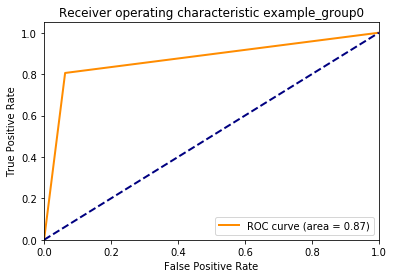

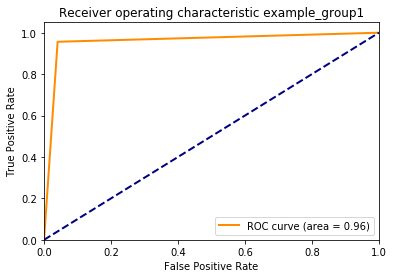

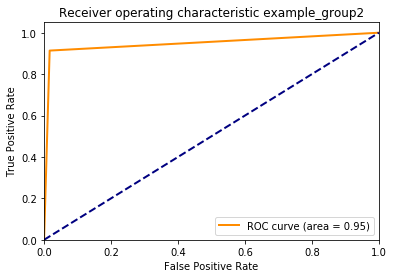

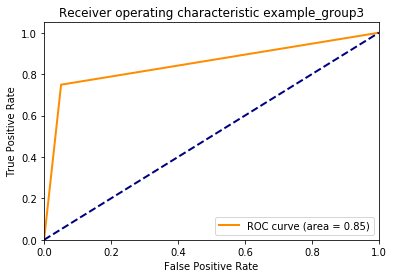

In [10]:
fpr = dict()
tpr = dict()
fnr = dict()
tnr = dict()
roc_auc = dict()

test_vectorized = label_binarize(test_target,classes=[0, 1, 2, 3])# student code
y = label_binarize(test_pred,classes=[0, 1, 2, 3]) #student code

for i in range(4):
    fpr[i], tpr[i], _ = roc_curve(test_vectorized[:,i],y[:,i]) # i column
    roc_auc[i] = auc(fpr[i], tpr[i])

conf_m=confusion_matrix(test_target,test_pred)

lw = 2
for i in range(4):
    plt.figure()
    plt.plot(fpr[i], tpr[i], color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc[i])
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example_group'+str(i))
    plt.legend(loc="lower right")
    filename="ROC_"+str(i)+"_bayes.png"
    plt.savefig(filename)

In [11]:
print conf_m

[[257   8   3  51]
 [  5 372   9   3]
 [  8  24 360   2]
 [ 52   7   4 188]]


In [12]:
print roc_auc

{0: 0.87138998199159612, 1: 0.95792088448943469, 2: 0.94851076893760955, 3: 0.84909364357452222}


In [13]:
from sklearn.decomposition import PCA
pca=PCA(n_components=2)
pca.fit(train_feature)
train_pca=pca.transform(train_feature)
train_class_pca=dict()
for i in range(4):
    train_class_pca[i]=pca.transform(train_class[i])
mu_pca = np.zeros([2,len(categories)], dtype=float)
for c in range(4):
    mu_pca[:,c]=np.mean(train_class_pca[c],axis=0).transpose()

In [14]:
cov_pca=np.cov(train_pca.transpose())
sigma_pca=sum(np.diagonal(cov_pca))/2
w_p=np.zeros([len(categories),2],dtype=float)
w0_p=np.zeros(len(categories),dtype=float)
for i in range(4):
    mu_p=mu_pca[:,i]
    w_p[i]=np.divide(mu_p,sigma_pca)
    w0_p[i]=1.0/(2*sigma_pca)* np.matmul(mu_p, mu_p)+ np.log(Pi[i])


In [15]:
def Bayes_b(w_p,w0_p):
    ax.set_xlim([-0.2, 0.4])
    ax.set_ylim([-0.4, 0.4])
    for i in range(4):
        for j in range(i+1,4):
            mu_x=mu_pca[0]
            mu_y=mu_pca[1]
            if mu_x[i]-mu_x[j]==0:
                print mu_x[i],mu_x[j]
            if mu_y[i]-mu_y[j]==0:
                print mu_y[i],mu_y[j]
            k=-(w_p[i][0]-w_p[j][0])/(w_p[i][1]-w_p[j][1])
            b=-(w0_p[i]-w0_p[j])/(w_p[i][1]-w_p[j][1])
            x = np.linspace(-0.2,0.4,10)
            y = k*x + b
            plt.plot(x,y, label='bayes boundary of %d and %d'%(i,j))

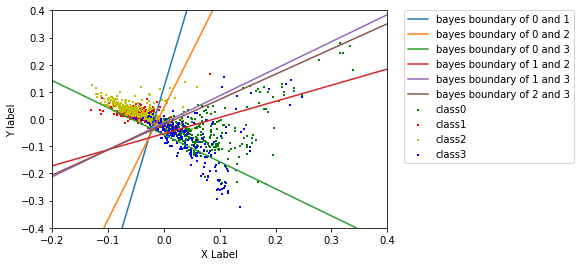

In [16]:
test_x=pca.transform(test_feature)
test_class=dict()
for c in range(4):
    test_class[c]=list()
for ind,feat in enumerate(test_x):
    target=test_target[ind]
    test_class[target].append(feat)
for c in range(4):
    test_class[c]=np.array(test_class[c])
color=['g','r','y','b']
fig=plt.figure()
ax=plt.gca()
for i in range(4):
    x_0=test_class[i][:,0]
    x_1=test_class[i][:,1]
    ax.scatter(x_0,x_1,c=color[i],marker='+',s=5,label='class%d'%i)
Bayes_b(w_p,w0_p)
ax.set_xlabel('X Label')
ax.set_ylabel('Y label')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
fil="bayes_boundary.png"
plt.show()

*Case 1: multivariate normals with shared axis parellel variances:*

- In this case, first compute the cov to be the diagonal matrix with the variance of each feasure on the diag, i.e. diag(diag(cov(x))).

In [19]:
cov = np.zeros([train_feature.shape[1],train_feature.shape[1],len(categories)])
cov_=np.cov(train_feature.transpose())
cov_=np.diag(np.diag(cov_))
print (det(cov_))
for i in range(4):
    cov[:,:,i]=cov_
W=np.zeros([train_feature.shape[1],train_feature.shape[1],len(categories)])
w_=np.zeros([len(categories),train_feature.shape[1]],dtype=float)
w0=np.zeros(len(categories),dtype=float)
g=np.zeros([len(categories),train_feature.shape[1]],dtype=float)

for i in range(4):
    mu_=mu[:,i]
    W[:,:,i]=-0.5*inv(cov_)
    w_[i]=np.matmul(inv(cov_),mu_)
    w0[i]=-0.5*np.dot(np.dot(mu_.transpose(),inv(cov_)),mu_)-0.5*det(cov_)+ np.log(Pi[i])

test_pred=np.zeros((test_feature.shape[0]))

for ind,feat in enumerate(test_feature):
    g=np.zeros(4,dtype=float)
    for c in range(4):
        g[c]=np.dot(feat.T,W[:,:,c]).dot(feat)+w_[c].T.dot(feat)+w0[c]
    test_pred[ind]=np.argmax(g)

0.0


In [85]:
case1_rate = (abs(test_pred-test_target)==0).mean()
print case1_rate

0.874353288987


In [86]:
fpr = dict()
tpr = dict()
fnr = dict()
tnr = dict()
roc_auc = dict()

test_vectorized = label_binarize(test_target,classes=[0, 1, 2, 3])# student code
y = label_binarize(test_pred,classes=[0, 1, 2, 3]) #student code

for i in range(4):
    fpr[i], tpr[i], _ = roc_curve(test_vectorized[:,i],y[:,i]) # i column
    roc_auc[i] = auc(fpr[i], tpr[i])

conf_m=confusion_matrix(test_target,test_pred)

lw = 2
for i in range(4):
    plt.figure()
    plt.plot(fpr[i], tpr[i], color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc[i])
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example_group'+str(i))
    plt.legend(loc="lower right")
    filename="ROC_"+str(i)+"_case1.png"
    plt.savefig(filename)

In [87]:
print conf_m

[[255  12  15  37]
 [  0 382   6   1]
 [  1  25 368   0]
 [ 33  23  17 178]]


In [88]:
print roc_auc

{0: 0.88324551457346756, 1: 0.95988223874388001, 2: 0.94719277165829474, 3: 0.83734029399642806}


In [91]:
cov_pca= np.zeros([2,2,len(categories)])
cov_p=np.cov(train_pca.transpose())
cov_p=np.diag(np.diag(cov_p))
for i in range(4):
    cov_pca[:,:,i]=cov_p
Wp=np.zeros([2,2,len(categories)])
w_p=np.zeros([len(categories),2],dtype=float)
w0_p=np.zeros(len(categories),dtype=float)
for i in range(4):
    mu_p=mu_pca[:,i]
    Wp[:,:,i]=-0.5*inv(cov_p)
    w_p[i]=np.matmul(inv(cov_p),mu_p)
    w0_p[i]=-0.5*np.dot(np.dot(mu_p.T,inv(cov_p)),mu_p)-0.5*det(cov_p)+ np.log(Pi[i])

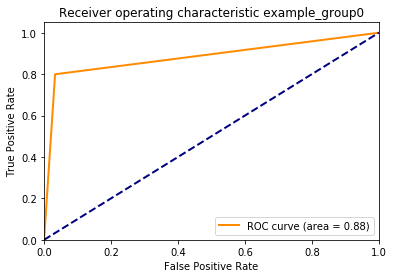

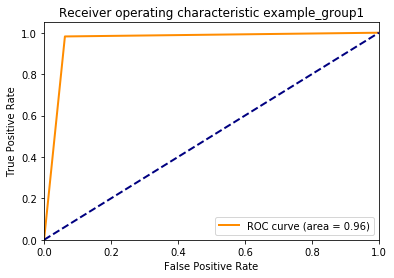

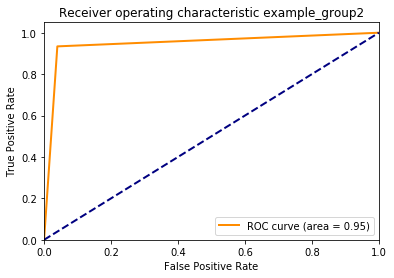

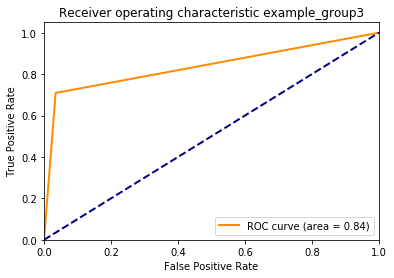

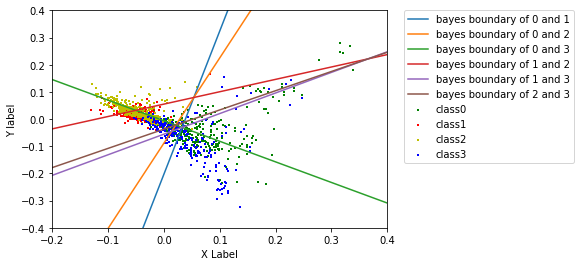

In [93]:
test_x=pca.transform(test_feature)
test_class=dict()
for c in range(4):
    test_class[c]=list()
for ind,feat in enumerate(test_x):
    target=test_target[ind]
    test_class[target].append(feat)
for c in range(4):
    test_class[c]=np.array(test_class[c])
color=['g','r','y','b']
fig=plt.figure()
ax=plt.gca()
for i in range(4):
    x_0=test_class[i][:,0]
    x_1=test_class[i][:,1]
    ax.scatter(x_0,x_1,c=color[i],marker='+',s=5,label='class%d'%i)
Bayes_b(w_p,w0_p)
ax.set_xlabel('X Label')
ax.set_ylabel('Y label')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
fil="bayes_b_class1.png"
plt.show()

*Case 2: multivariate normals with shared arbitrary variances:*

- In this case, first compute cov to be the general covariance matrix of feasures, i.e. cov(x).

In [97]:
cov = np.zeros([train_feature.shape[1],train_feature.shape[1],len(categories)])
cov_=np.cov(train_feature.transpose())
for i in range(4):
    cov[:,:,i]=cov_
W=np.zeros([train_feature.shape[1],train_feature.shape[1],len(categories)])
w_=np.zeros([len(categories),train_feature.shape[1]],dtype=float)
w0=np.zeros(len(categories),dtype=float)
g=np.zeros([len(categories),train_feature.shape[1]],dtype=float)

for i in range(4):
    mu_=mu[:,i]
    W[:,:,i]=-0.5*inv(cov_)
    w_[i]=np.matmul(inv(cov_),mu_)
    w0[i]=-0.5*np.dot(np.dot(mu_.transpose(),inv(cov_)),mu_)-0.5*det(cov_)+ np.log(Pi[i])

test_pred=np.zeros((test_feature.shape[0]))

for ind,feat in enumerate(test_feature):
    g=np.zeros(4,dtype=float)
    for c in range(4):
        g[c]=np.dot(feat.T,W[:,:,c]).dot(feat)+w_[c].T.dot(feat)+w0[c]
    test_pred[ind]=np.argmax(g)

In [99]:
case2_rate = (abs(test_pred-test_target)==0).mean()
print case2_rate

0.874353288987


In [ ]:
fpr = dict()
tpr = dict()
fnr = dict()
tnr = dict()
roc_auc = dict()

test_vectorized = label_binarize(test_target,classes=[0, 1, 2, 3])# student code
y = label_binarize(test_pred,classes=[0, 1, 2, 3]) #student code

for i in range(4):
    fpr[i], tpr[i], _ = roc_curve(test_vectorized[:,i],y[:,i]) # i column
    roc_auc[i] = auc(fpr[i], tpr[i])

conf_m=confusion_matrix(test_target,test_pred)

lw = 2
for i in range(4):
    plt.figure()
    plt.plot(fpr[i], tpr[i], color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc[i])
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example_group'+str(i))
    plt.legend(loc="lower right")
    filename="ROC_"+str(i)+"_case2.png"
    plt.savefig(filename)

In [100]:
print conf_m

[[255  12  15  37]
 [  0 382   6   1]
 [  1  25 368   0]
 [ 33  23  17 178]]


In [101]:
print roc_auc

{0: 0.88324551457346756, 1: 0.95988223874388001, 2: 0.94719277165829474, 3: 0.83734029399642806}


*Case 3: multivariate normals with shared spherical variances:*

- In this case, first compute a cov for each class.

In [102]:
cov = np.zeros([train_feature.shape[1],train_feature.shape[1],len(categories)])
sigma=np.zeros(4)
for i in range(4):
    cov_=np.cov(train_class[i].T)
    sigma[i]=sum(np.diag(cov_))/1500
    cov[:,:,i]=sigma[i]*np.eye(1500)
w=np.zeros([len(categories),train_feature.shape[1]],dtype=float)
w0=np.zeros(len(categories),dtype=float)
g=np.zeros([len(categories),train_feature.shape[1]],dtype=float)

for i in range(4):
    mu_=mu[:,i]
    w[i]=np.divide(mu_,sigma[i])
    w0[i]=1.0/(2*sigma[i])* np.matmul(mu_, mu_)+ np.log(Pi[i])
               
test_pred=np.zeros((test_feature.shape[0]))

for ind,feat in enumerate(test_feature):
    g=np.zeros(4,dtype=float)
    for c in range(4):
        g[c]=np.matmul(w[c],feat)+w0[c]
    test_pred[ind]=np.argmax(g)

In [103]:
case3_rate = (abs(test_pred-test_target)==0).mean()
print case3_rate

0.870657797487


In [105]:
fpr = dict()
tpr = dict()
fnr = dict()
tnr = dict()
roc_auc = dict()

test_vectorized = label_binarize(test_target,classes=[0, 1, 2, 3])# student code
y = label_binarize(test_pred,classes=[0, 1, 2, 3]) #student code

for i in range(4):
    fpr[i], tpr[i], _ = roc_curve(test_vectorized[:,i],y[:,i]) # i column
    roc_auc[i] = auc(fpr[i], tpr[i])

conf_m=confusion_matrix(test_target,test_pred)

lw = 2
for i in range(4):
    plt.figure()
    plt.plot(fpr[i], tpr[i], color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc[i])
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example_group'+str(i))
    plt.legend(loc="lower right")
    filename="ROC_"+str(i)+"_case3.png"
    plt.savefig(filename)

In [106]:
print conf_m

[[260   7   3  49]
 [  5 371  10   3]
 [  8  23 361   2]
 [ 54   7   4 186]]


In [107]:
print roc_auc

{0: 0.87512505836056831, 1: 0.95767288184407295, 2: 0.94925842803681926, 3: 0.84601702084583619}


Case 4: Same as case 3, but with reject option. Threshold 0.3

In [123]:
cov = np.zeros([train_feature.shape[1],train_feature.shape[1],len(categories)])
sigma=np.zeros(4)
for i in range(4):
    cov_=np.cov(train_class[i].T)
    sigma[i]=sum(np.diag(cov_))/1500
    cov[:,:,i]=sigma[i]*np.eye(1500)
w=np.zeros([len(categories),train_feature.shape[1]],dtype=float)
w0=np.zeros(len(categories),dtype=float)
g=np.zeros([len(categories),train_feature.shape[1]],dtype=float)

for i in range(4):
    mu_=mu[:,i]
    w[i]=np.divide(mu_,sigma[i])
    w0[i]=1.0/(2*sigma[i])* np.matmul(mu_, mu_)+ np.log(Pi[i])
               
test_pred=np.zeros((test_feature.shape[0]))

for thre in [0,0.2,0.25,0.3,0.35,0.4,0.45,0.5,0.6]: # 0.3 is best
    for ind,feat in enumerate(test_feature):
        g=np.zeros(4,dtype=float)
        for c in range(4):
            g[c]=np.matmul(w[c],feat)+w0[c]
        g_sum=sum(g)
        est=np.argsort(g)[3]
        if g[est]<g_sum*thre:
            test_pred[ind]=np.argsort(g)[2]
        else:
            test_pred[ind]=est 
    case4_rate = (abs(test_pred-test_target)==0).mean()
    print case4_rate

0.870657797487
0.870657797487
0.870657797487
0.871396895787
0.860310421286
0.834441980783
0.809312638581
0.761271249076
0.651884700665


In [114]:
case4_rate = (abs(test_pred-test_target)==0).mean()
print case4_rate

0.871396895787


In [118]:
fpr = dict()
tpr = dict()
fnr = dict()
tnr = dict()
roc_auc = dict()

test_vectorized = label_binarize(test_target,classes=[0, 1, 2, 3])# student code
y = label_binarize(test_pred,classes=[0, 1, 2, 3]) #student code

for i in range(4):
    fpr[i], tpr[i], _ = roc_curve(test_vectorized[:,i],y[:,i]) # i column
    roc_auc[i] = auc(fpr[i], tpr[i])

conf_m=confusion_matrix(test_target,test_pred)

lw = 2
for i in range(4):
    plt.figure()
    plt.plot(fpr[i], tpr[i], color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc[i])
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example_group'+str(i))
    plt.legend(loc="lower right")
    filename="ROC_"+str(i)+"_case4.png"
    plt.savefig(filename)

In [119]:
print conf_m

[[259  10   2  48]
 [  6 370  10   3]
 [  8  23 361   2]
 [ 53   5   4 189]]


In [120]:
print roc_auc

{0: 0.87355766024144599, 1: 0.95586886260120107, 2: 0.94977980447060462, 3: 0.85244683697153312}
